# Lab | Making predictions with Logistic Regression

In [1]:
# Lab | Making predictions with logistic regression
# In this lab, you will be using the Sakila database of movie rentals.

# In order to optimize our inventory, we would like to know which films will be rented next month 
# and we are asked to create a model to predict it.

# Instructions
# 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. 
# It should include some film features and some rental features.

# 2. Read the data into a Pandas dataframe.

# 3. Analyze extracted features and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.

# 4. Create a query to get the list of films and a boolean indicating if it was rented last month. 
#    This would be our target variable.

# 5. Create a logistic regression model to predict this variable from the cleaned data.

# 6. Evaluate the results.

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report

In [3]:
# 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. 
# which films will be rented next month?
# It should include some film features and some rental features.

password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
database = create_engine(connection_string)
query = '''
SELECT f.title, f.film_id, f.rating, f.rental_rate, f.language_id, f.release_year, f.rental_duration, f.length, f.replacement_cost, count(r.rental_id) as number_copies FROM sakila.film f
JOIN sakila.inventory i using(film_id)
JOIN sakila.rental r using(inventory_id)
GROUP BY f.title, f.film_id, f.rating, f.rental_rate, f.language_id, f.release_year, f.rental_duration, f.length, f.replacement_cost;
'''

········


In [4]:
# 2. Read the data into a Pandas dataframe.
df = pd.read_sql_query(query, database)
df.tail(20)

,title,film_id,rating,rental_rate,language_id,release_year,rental_duration,length,replacement_cost,number_copies
938,WOLVES DESIRE,981,NC-17,0.99,1,2006,7,55,13.99,21
939,WOMEN DORADO,982,R,0.99,1,2006,4,126,23.99,23
940,WON DARES,983,PG,2.99,1,2006,7,105,18.99,9
941,WONDERFUL DROP,984,NC-17,2.99,1,2006,3,126,20.99,9
942,WONDERLAND CHRISTMAS,985,PG,4.99,1,2006,4,111,19.99,22
943,WONKA SEA,986,NC-17,2.99,1,2006,6,85,24.99,18
944,WORDS HUNTER,987,PG,2.99,1,2006,3,116,13.99,16
945,WORKER TARZAN,988,R,2.99,1,2006,7,139,26.99,15
946,WORKING MICROCOSMOS,989,R,4.99,1,2006,4,74,22.99,25
947,WORLD LEATHERNECKS,990,PG-13,0.99,1,2006,3,171,13.99,8


In [5]:
# 3. Analyze extracted features and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.

# Check dimensions
df.shape

(958, 10)

In [6]:
# Check data types
df.dtypes

title                object
film_id               int64
rating               object
rental_rate         float64
language_id           int64
release_year          int64
rental_duration       int64
length                int64
replacement_cost    float64
number_copies         int64
dtype: object

In [7]:
# Check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             958 non-null    object 
 1   film_id           958 non-null    int64  
 2   rating            958 non-null    object 
 3   rental_rate       958 non-null    float64
 4   language_id       958 non-null    int64  
 5   release_year      958 non-null    int64  
 6   rental_duration   958 non-null    int64  
 7   length            958 non-null    int64  
 8   replacement_cost  958 non-null    float64
 9   number_copies     958 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 75.0+ KB


In [8]:
df.isna().sum() * 100 / len(df)

title               0.0
film_id             0.0
rating              0.0
rental_rate         0.0
language_id         0.0
release_year        0.0
rental_duration     0.0
length              0.0
replacement_cost    0.0
number_copies       0.0
dtype: float64

In [9]:
# Drop language_id, release_year due to only constant values

df = df.drop(['language_id','release_year'], axis=1)

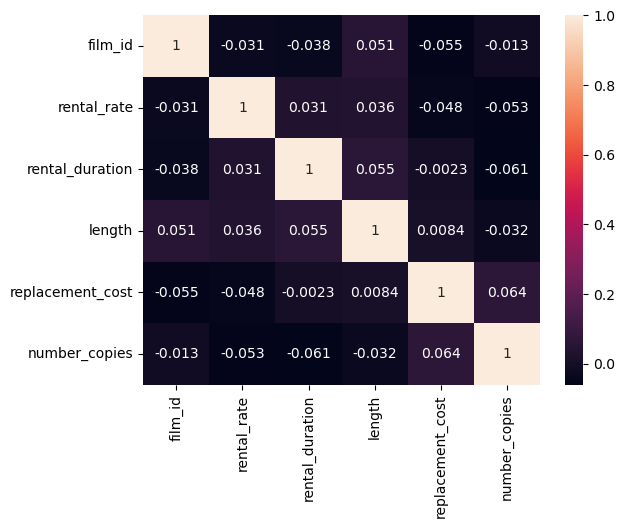

In [10]:
# Check multi collinearity  =  remove variables that have high correlation
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

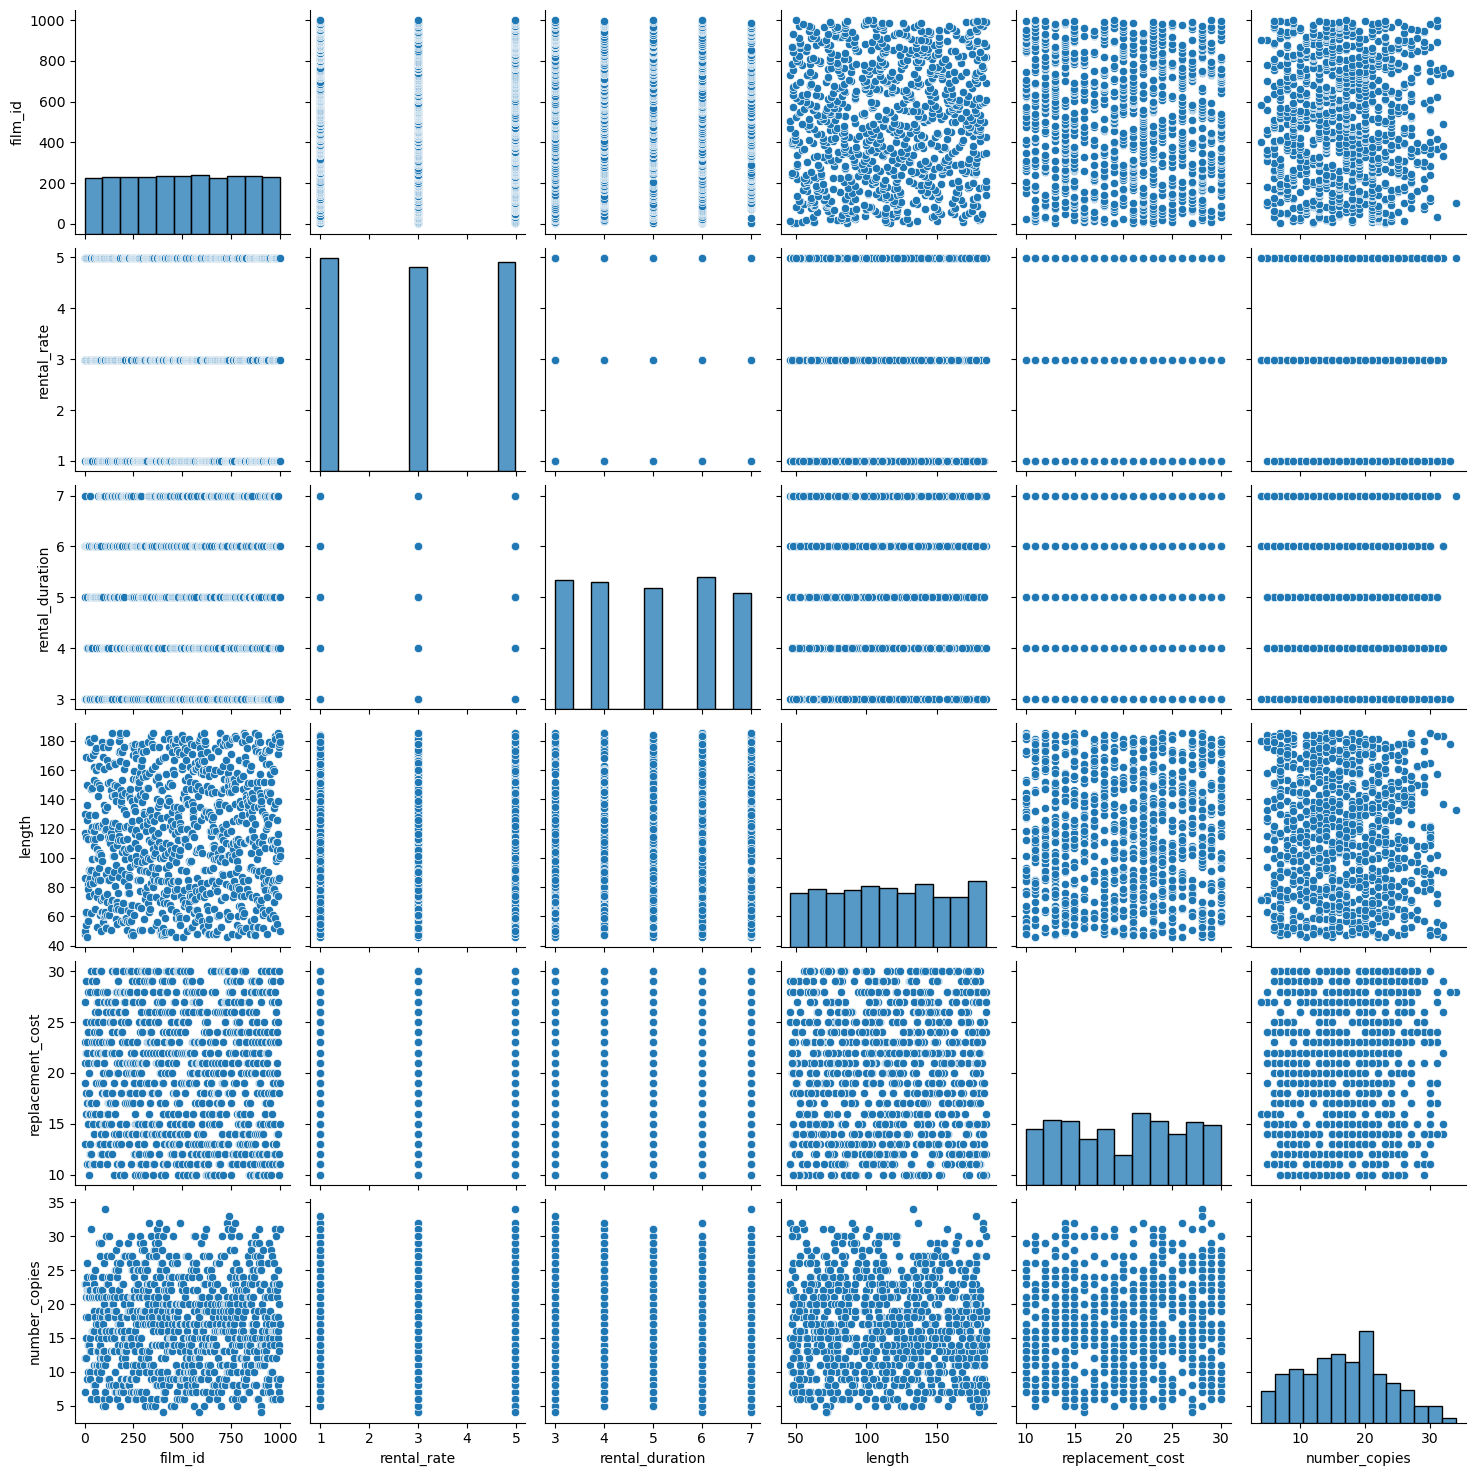

In [11]:
# Check if variables are normally distributed
sns.pairplot(df)

In [12]:
X_film = df.select_dtypes(include = np.number)
X_film.head()

,film_id,rental_rate,rental_duration,length,replacement_cost,number_copies
0,1,0.99,6,86,20.99,23
1,2,4.99,3,48,12.99,7
2,3,2.99,7,50,18.99,12
3,4,2.99,5,117,26.99,23
4,5,2.99,6,130,22.99,12


In [13]:
x = X_film.copy()

x = x.drop('film_id', axis=1)
x.head()

,rental_rate,rental_duration,length,replacement_cost,number_copies
0,0.99,6,86,20.99,23
1,4.99,3,48,12.99,7
2,2.99,7,50,18.99,12
3,2.99,5,117,26.99,23
4,2.99,6,130,22.99,12


In [14]:
def standard_scaler(df):
    columns = df.columns
    df_copy = pd.DataFrame(StandardScaler().fit(df).transform(df))
    df_copy.columns = columns
    return df_copy

In [15]:
x = standard_scaler(x)
x.head()

,rental_rate,rental_duration,length,replacement_cost,number_copies
0,-1.210182,0.732321,-0.729050,0.153556,0.937044
1,1.225436,-1.400090,-1.668465,-1.167269,-1.460787
2,0.007627,1.443124,-1.619022,-0.176650,-0.711465
3,0.007627,0.021517,0.037314,1.144175,0.937044
4,0.007627,0.732321,0.358693,0.483762,-0.711465


In [16]:
# Deal with categorical data

cat_film = df.select_dtypes(include = object)
cat_film

,title,rating
0,ACADEMY DINOSAUR,PG
1,ACE GOLDFINGER,G
2,ADAPTATION HOLES,NC-17
3,AFFAIR PREJUDICE,G
4,AFRICAN EGG,G
...,...,...
953,YOUNG LANGUAGE,G
954,YOUTH KICK,NC-17
955,ZHIVAGO CORE,NC-17
956,ZOOLANDER FICTION,R


In [17]:
cat = cat_film.copy()

cat = cat.drop('title', axis=1)
cat.head()
cat.value_counts()

rating
PG-13     213
NC-17     202
R         189
PG        183
G         171
dtype: int64

In [18]:
# Encode categorical variable 

categorical = pd.get_dummies(cat, columns=['rating'])
categorical

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
953,1,0,0,0,0
954,0,1,0,0,0
955,0,1,0,0,0
956,0,0,0,0,1


In [19]:
# Join sets of data together and save dependent variable
X = pd.concat((x,categorical), axis=1)
X.head()

,rental_rate,rental_duration,length,replacement_cost,number_copies,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,-1.210182,0.732321,-0.729050,0.153556,0.937044,0,0,1,0,0
1,1.225436,-1.400090,-1.668465,-1.167269,-1.460787,1,0,0,0,0
2,0.007627,1.443124,-1.619022,-0.176650,-0.711465,0,1,0,0,0
3,0.007627,0.021517,0.037314,1.144175,0.937044,1,0,0,0,0
4,0.007627,0.732321,0.358693,0.483762,-0.711465,1,0,0,0,0


In [20]:
# 4. Create a query to get the list of films and a boolean indicating if it was rented last month. 
#    This would be our target variable.

query = '''
SELECT DISTINCT f.title, 
	CASE WHEN max(r.rental_date) = (SELECT max(rental_date) FROM sakila.rental) THEN 'True'
    ELSE 'False'
    END AS 'boolean'
FROM sakila.film f 
JOIN sakila.inventory i USING(film_id)
JOIN sakila.rental r USING(inventory_id)
GROUP BY 1;
'''
y_film = pd.read_sql_query(query, database)
y_film.head()

,title,boolean
0,ACADEMY DINOSAUR,False
1,ACE GOLDFINGER,True
2,ADAPTATION HOLES,False
3,AFFAIR PREJUDICE,True
4,AFRICAN EGG,True


In [21]:
y = y_film['boolean']

<AxesSubplot:xlabel='boolean', ylabel='count'>

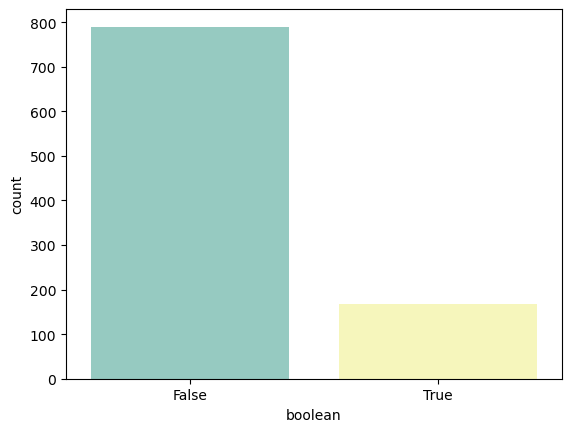

In [22]:
# Investigate the distribution of the y variable

sns.countplot(x = y, data = df, palette = 'Set3')

In [24]:
# 5. Create a logistic regression model to predict this variable from the cleaned data.
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.4)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(574, 10)
(574,)
(384, 10)
(384,)


<AxesSubplot:xlabel='boolean', ylabel='count'>

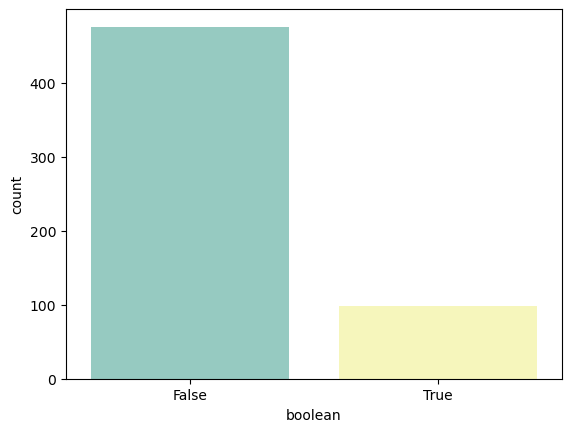

In [25]:
sns.countplot(x = y_train, data = X_train, palette = 'Set3')

<AxesSubplot:xlabel='boolean', ylabel='count'>

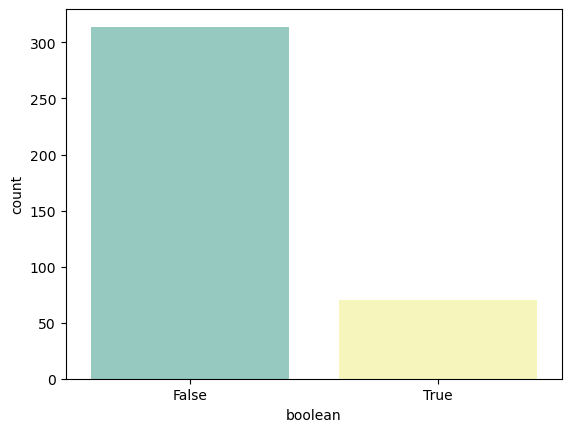

In [26]:
sns.countplot(x = y_test, data = X_test, palette = 'Set3')

In [27]:
model = LogisticRegression().fit(X_train, y_train)

In [28]:
# Predict Y for X_test values:

y_pred = model.predict(X_test)

In [29]:
# Evaluating the model accuracy:
print('The test accuracy is ', model.score(X_test, y_test))
print('The train accuracy is ', model.score(X_train,y_train))

The test accuracy is  0.8177083333333334
The train accuracy is  0.8292682926829268


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      1.00      0.90       314
        True       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41      0.50      0.45       384
weighted avg       0.67      0.82      0.74       384



C:\Users\garpa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\garpa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\garpa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


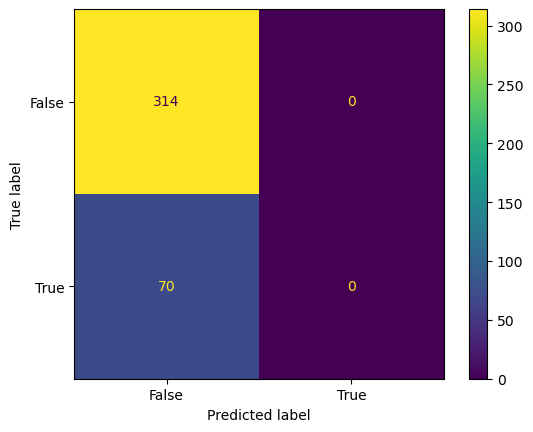

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

In [32]:
#The model is imbalanced. See processing sequence in Lab | Imbalance Data